# 1-D Heat Equation (Explicit Method)

**강좌**: *수치해석 프로젝트*

## Heat Equation (1-D)
열전도에 의한 열유속 (Heat Flux)는 Fourier Law에 의해 표현할 수 있다.

$$
\dot{q} = -k \frac{dT}{dx}
$$

여기서 $T$는 온도, $k$ 는 열전도 계수이고, $\dot{q}$ 는 열유속 ($W/m^2$) 이다.

단위 길이 $\Delta x$ 에 대해서 내부에너지 변화는 열유속의 구배와 같다.

$$
\rho C_p \frac{dT}{dt} = \lim_{\Delta x \rightarrow 0} 
\frac{\dot{q} + \dot{q}_x \Delta x - \dot{q}}{\Delta x} = -k \frac{d^2T}{dx^2}
$$

이를 정리하면 1차원 Heat equation 이다.

$$
\frac{dT}{dt} = \alpha \frac{d^2T}{dx^2}.
$$

:::{figure-md} markdown-fig
<img src="https://upload.wikimedia.org/wikipedia/commons/2/2d/Heat-conduction.svg" alt="conduction-fig">

Heat Conduction (image from wikimedia.org)
:::

## Finite Difference Method
Finite Difference 를 이용해서 이 편미분 방정식은 다음과 같이 표현할 수 있다.

### FTCS (Forward difference in Time, Central difference in Space)
$$
\frac{T(x,t+\Delta t) - T(x, t)}{\Delta t} 
=
\alpha \frac {T(x + \Delta x, t) -2 T(x, t) + T(x - \Delta x, t)}{\Delta x^2} + O((\Delta t), (\Delta x)^2)
$$

여기서 시간과 공간을 각각 M, N 개로 나누고, $(n, i)$ 점에서 값을 다음과 같이 간단히 표시하자

$$
T(x_i, t_n) = T_i^n
$$

:::{figure-md} markdown-fig
<img src="https://i.stack.imgur.com/PihC7.png" alt="stencil-fig">

FTCS Stencil
:::

그 결과 위 차분식 (FDE, Finite Difference Equation)은 다음과 같이 표현할 수 있다.

$$
\frac{T_i^{n+1}- T_i^n}{\Delta t} 
=
\alpha \frac {T_{i+1}^n -2 T_i^n +  T_{i-1}^n}{\Delta x^2}
$$

### 예제
$\alpha=0.1$ 이고 $x\in [0, 1]$ 에 대해서 해석한다.

- 초기 조건 : $T(x,0) = 100$
- 경계 조건 : $T(0, t) = 100$, $T(1, t) = 300$

$\Delta t =0.005, \Delta x=0.1$ 에 $t=1$ 일때 온도 분포를 구하시오.

*참고* Exact Solution은 변수 분리법에 따라 다음과 같다.

$$
T = T_s x + \sum_{n=1}^{\infty} \frac{2 T_s (-1)^n}{n \pi} e^{-n^2 \pi^2 \alpha t} \sin(n \pi x)
$$

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150

In [2]:
def cs(u, du, adtdx2):
    """
    Central difference in space
    
    Parameters
    ----------
    u : array
        solution
    du : array
        difference
    adtdx2 : float
        constant
    """
    n = len(u)
    for i in range(1, n-1):
        du[i] = adtdx2*(u[i-1] -2*u[i] + u[i+1])

In [3]:
def cs_v1(u, adx2):
    """
    Central difference in space
    
    Parameters
    ----------
    u : array
        solution
    adx2 : float
        constant
        
    Returns
    -------
    du : array
        difference    
    """
    return adx2*(u[:-2] - 2*u[1:-1] + u[2:])

Error: 0.09609


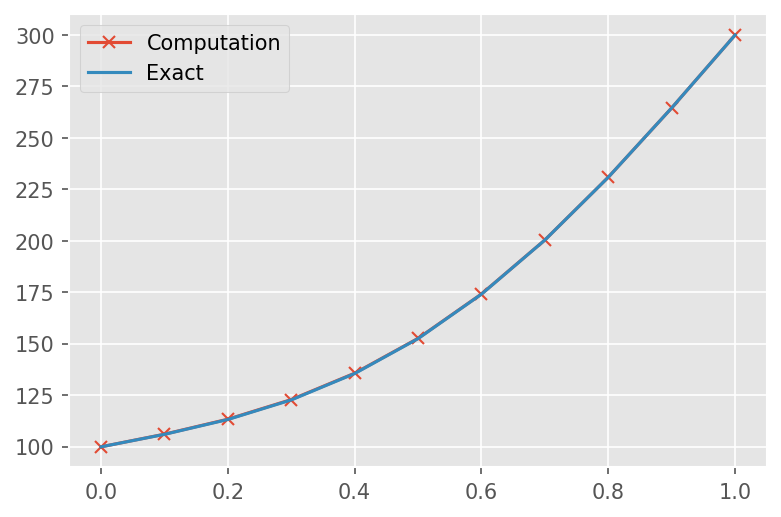

In [4]:
# Conditions
alpha = 0.1
ti = 100
ts = 300

t_target = 1.0
dt = 0.005

# Make grid
nx = 11
x = np.linspace(0, 1, nx)
dx = np.diff(x)[0]

# Const
adx2 = alpha / dx**2

# Solution array
u = np.ones_like(x)*ti
du = np.zeros_like(u)

# Calculation
t = 0
while abs(t - t_target) > 1e-10:
    # Adjust time step to reach target time
    dt = min(dt, t_target - t)

    # Apply bc
    u[0] = ti
    u[-1] = ts
    
    # Spatial discretization
    #cs(u, du, adx2*dt)
    du[1:-1] = dt*cs_v1(u, adx2)
    
    # Update solution and time
    u += du
    t += dt

# Exact solution
dts = ts - ti
u_exact = ti + dts*x + np.sum([
    2*dts*(-1)**n / (n*np.pi) *np.exp(-n**2*np.pi**2*alpha*t)*np.sin(n*np.pi*x) 
    for n in range(1, 10)
], axis=0)

# Visualization
plt.plot(x, u, marker='x')
plt.plot(x, u_exact)
plt.legend(['Computation', 'Exact'])

# Compute Error
err = np.linalg.norm(u[1:-1] - u_exact[1:-1])
err = u - u_exact
err = np.sqrt(np.sum(err**2) / nx)
print('Error: {:.5f}'.format(err))

#### 정확도
FTCS 의 Truncation Error 는 $O((\Delta t), (\Delta x)^2)$ 이다.
즉 공간 차분에 대해서 2차 정확도를 갖는다. 

이를 확인하기 위해서 $\Delta t = 10^{-5}$ 로 매우 작게 한 후
$\Delta x$ 를 절반으로 줄여가면서 계산하였다.

Exact solution 과의 오차는 다음과 같이 계산한다.

$$
L^2 Error = \sqrt{\frac{1}{N} \sum (T-T_{exact})^2}
$$

Log-Log 그래프에서 기울기가 -2 이므로 2차 공간정확도를 갖는 것을 알 수 있다.

Text(0, 0.5, 'Error')

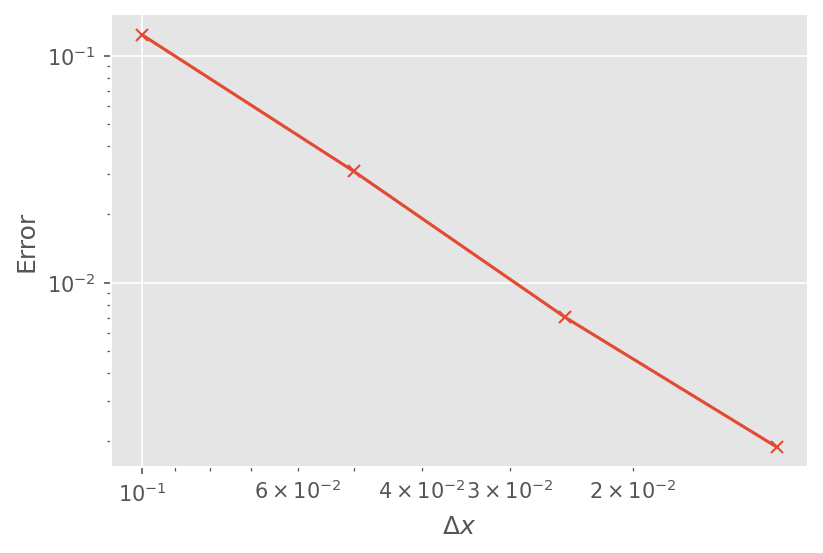

In [5]:
dxs = [0.1, 0.05, 0.025, 0.0125]
errs = [0.12344, 0.03097, 0.00704, 0.00189]

plt.loglog(dxs, errs, marker='x')
plt.gca().invert_xaxis()
plt.xlabel(r"$\Delta x$")
plt.ylabel("Error")

### 수치 안정성
#### Matrix Stability
PDE를 공간에 대해서만 차분하면 System of ODE로 생각할 수 있다.

$$
\frac{\partial T_i}{\partial t}
=
\alpha \frac {T_{i+1}^n -2 T_i^n +  T_{i-1}^n}{\Delta x^2}
$$

이를 Matrix 형태로 표현하면 다음과 같다.

$$
\frac{\partial}{\partial t}\left [
\begin{matrix}
T_1 \\ T_2 \\  T_3 \\ ... \\T_n
\end{matrix}
\right ]
= \frac{\alpha }{\Delta x^2} \left [
\begin{matrix}
-2 & 1 & 0 & ... & 0 \\
1 & -2 & 1 & ....& 0 \\
0 & 1 & -2 & ... & 0 \\
... & ... & ... & ... & ... \\
0 & 0 & 0 & ... &-2 \\
\end{matrix}
\right ]
\left [
\begin{matrix}
T_1 \\ T_2 \\  T_3 \\ ... \\T_n
\end{matrix}
\right ]
$$

즉 Banded Matrix $[1 -2 1]$ 의 Eigenvalue의 최대값이 Explicit Euler의 안정 영역 내 있어야 한다.
이렇게 안정성을 파악하는 방법을 Matrix Stability라 한다.

#### von Neumann Stability
일반적으로 Matrix의 Eigenvalue를 이론적으로 구하기 쉽지 않다. 좀 더 간단한 방법이 von Nuemann Analysis 이다.

아래 조건에서 적용할 수 있다.

- Linear, constant coefficient

- Uniformly spaced spatial grid

- Periodic boundary condition

이 방법에서는 Solution을 다음과 같은 형태로 생각한다.

$$
T_j^n = \sigma^n e^{ikx_j}
$$

이를 차분식에 적용하면

$$
\frac{\sigma^{n+1} e^{ikx_j} - \sigma^n e^{ikx_j}}{\Delta t} 
=
\alpha \frac {\sigma^n e^{ikx_{j+1}} -2 \sigma^n e^{ikx_j} +  \sigma^n e^{ikx_{j-1}}}{\Delta x^2}
$$

정리하면

$$
\sigma = 1 + \frac{\alpha \Delta t}{\Delta x^2} (2 \cos (k\Delta x) - 2)
$$

$|\sigma| < 1$ 을 만족하기 위해서는

$$
1 + \frac{\alpha \Delta t}{\Delta x^2} (2 \cos (k\Delta x) - 2) \geq -2
$$

즉 

$$
\Delta t \leq \frac{\Delta x^2}{\alpha (1 - \cos (k\Delta x))} \leq \frac{\Delta x^2}{2 \alpha}
$$

#### Modified Wavenumber
Modified wavenumber 방법은 von Neumann 방법과 비슷하며 같은 조건에서 활용 가능하다.

우선 PDE Solution을 $T(x, t) = \psi(t) e^{ikx}$ 로 생각한다. 이를 PDE에 적용하면

$$
\frac{d\psi}{dt} = - \alpha k^2 \psi
$$

FDE를 적용했을 때 Wavenumber $k$가 어떻게 달라지는지 확인해보자.

공간에 대해서만 차분된 방정식의 solution을 $T_j (t) = \psi(t) e^{ikx_j}$로 생각한다.
이를 차분식에 적용하면

$$
\frac{d\psi}{dt} = -\frac{2 \alpha}{\Delta x^2} (1 - \cos (k\Delta x)) \psi= -\alpha k`^2 \psi
$$

차분식에서 변형된 wavenumber $k`$ 은 다음과 같다.

$$
k`^2 = \frac{2}{\Delta x^2} (1 - \cos (k\Delta x))
$$

Model 방정식 형태로 생각하면 $\lambda = -\alpha k`^2$이다. Explicit Euler 기법에서 안정성 영역은

$$
\Delta t \leq \frac{2}{|\lambda|} = \frac{\Delta x^2}{2 \alpha}
$$

4th order Runge Kutta 기법의 안정성 영역에 만족하려면

$$
\Delta t \leq \frac{2.79}{|\lambda|} = \frac{2.79 \Delta x^2}{4 \alpha}
$$

## Lax Equivalance Theorem

Finite Difference Method의 해가 수렴할 필요 충분 조건은 consistency와 Stability 이다.

- Consistency : FDE가 PDE를 근사화 함

- Stability : FDE의 해의 오차가 감쇄함